In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


## Load dataset

In [4]:
# Load both datasets
fake_df = pd.read_csv("data/Fake.csv")
true_df = pd.read_csv("data/True.csv")

# Add a label column
fake_df["label"] = 0  # fake
true_df["label"] = 1  # true

# Combine them
df = pd.concat([fake_df, true_df], ignore_index=True)

# Shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

# Quick look
df.head()


,title,text,subject,date,label
0,U.S. government watchdog calls for changes in ...,WASHINGTON (Reuters) - Even as thousands of ad...,worldnews,"September 21, 2017",1
1,Obama to host Italy's Renzi for state visit Oc...,WASHINGTON (Reuters) - President Barack Obama ...,politicsNews,"September 12, 2016",1
2,Gunfire heard in Eritrea's capital as protests...,NAIROBI (Reuters) - The U.S. embassy in Eritre...,worldnews,"November 1, 2017",1
3,U.S. Democrats try to force vote on independen...,"WASHINGTON (Reuters) - (This May 17 story, in ...",politicsNews,"May 17, 2017",1
4,Trump Throws Twitter Tantrum Bashing Republic...,Donald Trump went on a tirade on Friday mornin...,News,"July 14, 2017",0


# 🔍 Check for missing data

In [5]:
print(df.isnull().sum())

title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [6]:
df['original_text'] = df['title'] + " " + df['text']


# Text Preprocessing Function

In [7]:
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', ' ', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words with numbers
    return text

In [8]:
df['cleaned_text'] = df['original_text'].apply(clean_text)


In [9]:
# Apply Cleaning
df['text'] = df['title'] + " " + df['text']  # Combine title and body
df['text'] = df['text'].apply(clean_text)

# Final preview
df[['text', 'label']].head()


,text,label
0,us government watchdog calls for changes in af...,1
1,obama to host italys renzi for state visit oct...,1
2,gunfire heard in eritreas capital as protests ...,1
3,us democrats try to force vote on independent ...,1
4,trump throws twitter tantrum bashing republic...,0


In [10]:
df[['original_text', 'cleaned_text']].head(10)


,original_text,cleaned_text
0,U.S. government watchdog calls for changes in ...,us government watchdog calls for changes in af...
1,Obama to host Italy's Renzi for state visit Oc...,obama to host italys renzi for state visit oct...
2,Gunfire heard in Eritrea's capital as protests...,gunfire heard in eritreas capital as protests ...
3,U.S. Democrats try to force vote on independen...,us democrats try to force vote on independent ...
4,Trump Throws Twitter Tantrum Bashing Republic...,trump throws twitter tantrum bashing republic...
5,Pentagon seeks $583 billion budget for 2017; R...,pentagon seeks billion budget for republican...
6,TOM DELAY DROPS A BOMB On What FBI Sources Say...,tom delay drops a bomb on what fbi sources say...
7,MAINE DEMOCRAT Congressman Makes DEATH THREAT ...,maine democrat congressman makes death threat ...
8,WATCH: PRESIDENT TRUMP CHANNELS Successful Dev...,watch president trump channels successful deve...
9,Exxon must confer with New York AG on Tillerso...,exxon must confer with new york ag on tillerso...


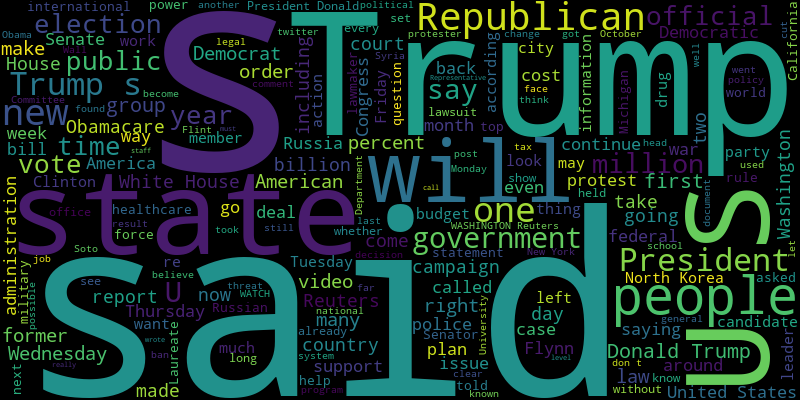

In [11]:
from wordcloud import WordCloud

# Before cleaning
WordCloud(width=800, height=400).generate(" ".join(df['original_text'][:100])).to_image()

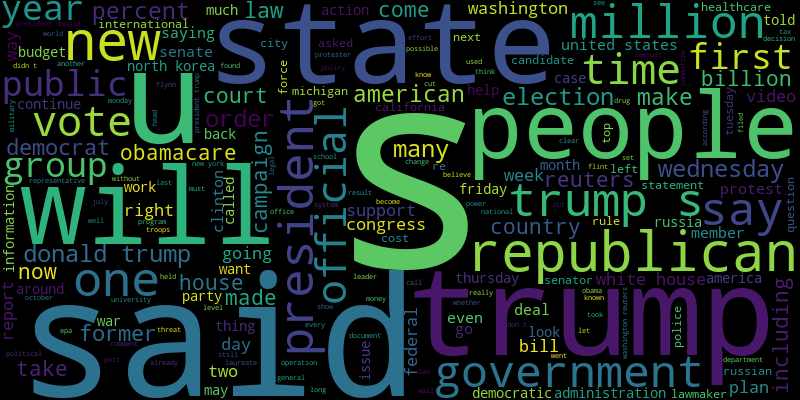

In [12]:
# After cleaning
WordCloud(width=800, height=400).generate(" ".join(df['cleaned_text'][:100])).to_image()

In [13]:
print("Duplicates:", df.duplicated().sum())

Duplicates: 209


In [14]:
# 🧹 Remove duplicates
df = df.drop_duplicates()

In [15]:
print("Duplicates:", df.duplicated().sum())

Duplicates: 0


# 📤 Split the data

In [16]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#  TF-IDF Vectorization

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import cross_val_score

# Create a pipeline that vectorizes text then classifies
model = make_pipeline(
    TfidfVectorizer(stop_words='english', max_df=0.7),
    PassiveAggressiveClassifier(max_iter=1000)
)

# Run 5-fold cross-validation on your full dataset (X and y)
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print("Cross-validation accuracy scores:", scores)
print("Mean CV accuracy:", scores.mean())


Cross-validation accuracy scores: [0.99586037 0.99429403 0.99485343 0.99530096 0.9940696 ]
Mean CV accuracy: 0.9948756784425665


# 🤖 Train the Model

In [19]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model = PassiveAggressiveClassifier(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = model.predict(X_test_tfidf)


# 📊 Evaluate the Model

Accuracy: 0.9953009621839337

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4667
           1       1.00      0.99      1.00      4271

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938



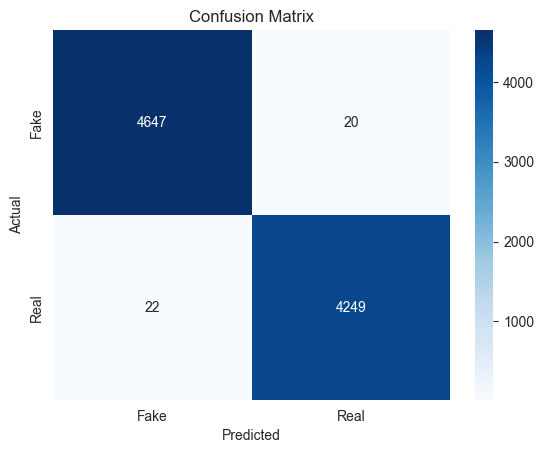

In [20]:

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [21]:
from matplotlib.pyplot import clf


def predict_user_input(text):
    # Transform the text using your trained TF-IDF vectorizer
    text_tfidf = vectorizer.transform([text])
    # Predict using your trained classifier
    prediction = model.predict(text_tfidf)[0]
    # Convert label to readable string
    label = "Fake News" if prediction == 0 else "Real News"
    return label

# Example interactive test
while True:
    user_text = input("Enter news text (or type 'exit' to quit):\n")
    if user_text.lower() == "exit":
        break
    result = predict_user_input(user_text)
    print(f"Prediction: {result}\n")


Prediction: Fake News



KeyboardInterrupt: Interrupted by user

As can be ssen before our classical model does not predict accuratly as classical models like PassiveAggressiveClassifier with TF-IDF are great for simple patterns but struggle with sentences or topics they haven’t seen before — they lack true understanding of language context.

Accuracy: 0.9945177892145894

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      4667
           1       0.99      0.99      0.99      4271

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



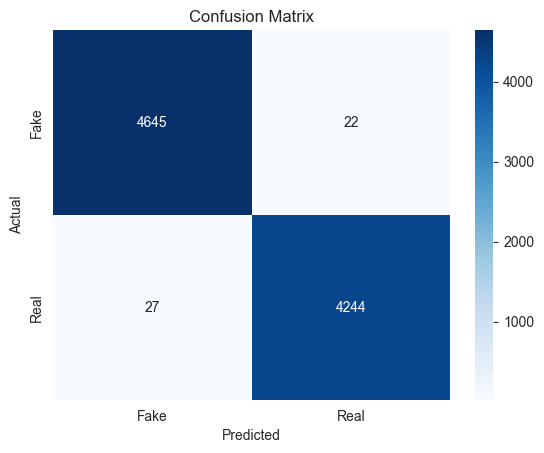

In [25]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Vectorize text
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Logistic Regression with Cross-Validation
model = LogisticRegressionCV(cv=5, max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Predict
y_pred = model.predict(X_test_tfidf)

# Results
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [26]:
def predict_news(text):
    vect_text = vectorizer.transform([text])
    pred = model.predict(vect_text)[0]
    label = "Real" if pred == 1 else "Fake"
    return label

# Test example
print(predict_news("Scientists have discovered a new treatment for cancer."))
print(predict_news("Breaking news: Aliens have landed on Earth!"))


Fake
Fake


In [27]:
print(y_train.value_counts())


label
0    18811
1    16940
Name: count, dtype: int64


In [28]:
samples = [
    "The government has passed new laws to support renewable energy.",
    "Celebrity endorses miracle cure that doctors hate.",
    "Local man wins lottery twice in one year.",
    "Experts confirm climate change effects accelerating.",
    "Unbelievable! This secret trick will make you rich overnight!"
]

for sample in samples:
    print(sample)
    print("Prediction:", predict_news(sample))
    print()


The government has passed new laws to support renewable energy.
Prediction: Fake

Celebrity endorses miracle cure that doctors hate.
Prediction: Fake

Local man wins lottery twice in one year.
Prediction: Fake

Experts confirm climate change effects accelerating.
Prediction: Fake

Unbelievable! This secret trick will make you rich overnight!
Prediction: Fake



In [29]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_tfidf, y_train)

y_pred_rf = model_rf.predict(X_test_tfidf)
print("Accuracy RF:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Accuracy RF: 0.9857910046990378
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4667
           1       0.99      0.98      0.99      4271

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



In [30]:
samples = [
    "The government has passed new laws to support renewable energy.",
    "Celebrity endorses miracle cure that doctors hate.",
    "Local man wins lottery twice in one year.",
    "Experts confirm climate change effects accelerating.",
    "Unbelievable! This secret trick will make you rich overnight!"
]

for sample in samples:
    print(sample)
    print("Prediction:", predict_news(sample))
    print()


The government has passed new laws to support renewable energy.
Prediction: Fake

Celebrity endorses miracle cure that doctors hate.
Prediction: Fake

Local man wins lottery twice in one year.
Prediction: Fake

Experts confirm climate change effects accelerating.
Prediction: Fake

Unbelievable! This secret trick will make you rich overnight!
Prediction: Fake



In [31]:
from datasets import Dataset

# Map labels to strings (optional, BERT can handle integers)
label_map = {0: "FAKE", 1: "REAL"}
df['label_str'] = df['label'].map(label_map)

dataset = Dataset.from_pandas(df[['text', 'label']])


TypeError: tokenize_function() got an unexpected keyword argument 'batched'

In [ ]:

# Split your data
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Convert labels to strings because transformers use text labels
y_train_str = y_train.map({0: "FAKE", 1: "REAL"})
y_test_str = y_test.map({0: "FAKE", 1: "REAL"})

# Save to files (BERT pipeline expects files or HuggingFace datasets)
train_data = [{'text': t, 'label': l} for t, l in zip(X_train, y_train_str)]
test_data = [{'text': t, 'label': l} for t, l in zip(X_test, y_test_str)]
